## Settings

In [1]:
%cd /content/drive/MyDrive/Dyetec

/content/drive/MyDrive/Dyetec


In [2]:
!pip install colormath

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for colormath: filename=colormath-3.0.0-py3-none-any.whl size=39408 sha256=5bfffa33e5725e8f8c0a45d7d8d3a0f3c31abf727e05716f083c18f44d301424
  Stored in directory: /root/.cache/pip/wheels/1a/d7/a7/458a4632ccc8bfe436f5e9db9fef1aa84e5d243a1b4b4c7b59
Successfully built colormath


In [51]:
import os
import random
import pandas as pd
import numpy as np
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

import matplotlib.pyplot as plt
import seaborn as sns

from colormath.color_objects import LabColor
from colormath.color_diff import delta_e_cmc

from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import plot_importance
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

### Configurations

In [4]:
SEED = 42
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)

seed_everything(SEED)

In [5]:
#=====  XGBoost  =====
BOOSTER = 'gbtree' # default. Gradient Boosting tree
LR = 0.1
MAX_DEPTH = 20
N_ESTIMATORS = 100
OBJECTIVE = 'reg:squarederror'
SILENT = False
SUBSAMPLE = 1.0  # Subsample ratio from the training set

colsample_bylevel = 1.0
colsample_bytree = 1.0
EARLY_STOPPING_ROUNDS = 10  # 에러가 n번 증가하면 학습 중단, default 10
GAMMA = 0.0
MAX_DELTA_STEP = 0.0
min_child_weights = 1.0 # Minimum sum of weights needed in each child node for a split.
num_parallel_tree = 1

# 'dart'인 경우에만 적용 - overfitting 방지
NORMALIZE_TYPE = 'tree'  # how to normalize trees, default 'tree'
ONE_DROP = True          # 1개 이상의 트리를 드롭아웃
RATE_DROP = 0.5          # 각 트리를 드롭아웃할 확률, default 0.0
REG_ALPHA = 0.2          # L1 regularization on the weights, default 0.0
REG_LAMBDA = 0.8         # L2 regularization on the weights, default 1.0
SAMPLE_TYPE = 'weighted' # 드롭아웃 확률을 트리의 가중치에 비례하게, default 'uniform'
SKIP_DROP = 0.2          # skipping the dropout during a given iteration, default 0.0


In [6]:
model_xgb = MultiOutputRegressor(xgb.XGBRegressor(
    booster=BOOSTER, # 'dart': Adds dropout to the standard gradient boosting algorithm
    learning_rate=LR,
    max_depth=MAX_DEPTH,
    n_estimators=N_ESTIMATORS,
    objective=OBJECTIVE,
    silent=SILENT,
    subsample=SUBSAMPLE,
))

In [9]:
kr2en = {'Lab 후가공 후 검사_L*': 'L*', 
         'Lab 후가공 후 검사_a*': 'a*', 
         'Lab 후가공 후 검사_b*': 'b*',
         '전처리_CH3COOH': 'prep_CH3COOH', 
         '제직_중량_생지': 'weaving_dough', 
         '배합_Sera Fast P-UVC': 'comb_Sera Fast', 
         '배합_UVK-400 H/C': 'comb_UVK400', 
         '배합_Fadex® TS liq': 'comb_Fadex', 
         '배합_빙초산': 'comb_acid',
         '배합_UVK-200': 'comb_UVK200',
         'Lab 염색 상승속도 #1': 'dye_up_rate1', 
         'Lab 염색 상승속도 #2': 'dye_up_rate2', 
         'Lab 염색 상승속도 #3': 'dye_up_rate3', 
         'Lab 염색 상승온도 #3': 'dye_up_temp3', 
         'Lab 염색 상승온도 #3 유지시간': 'dye_up_temp3_hold', 
         'Lab 염색 하강속도 #1': 'dye_down_rate1',
         '후처리_Sera Con M-FAS': 'after_Sera', 
         '후처리_NaOH': 'after_NaOH'
}

In [7]:
def compute_delta_e(y_test, y_pred):
    delta_E = []
    for i, (L_pred, a_pred, b_pred) in enumerate(y_pred):
        L_test, a_test, b_test = y_test.iloc[i].values
        target_color = LabColor(L_test, a_test, b_test)
        pred_color = LabColor(L_pred, a_pred, b_pred)
        delta_E.append(delta_e_cmc(target_color, pred_color, pl=2, pc=1))
    return delta_E

## Data Loading

In [8]:
df_origin = pd.read_csv('data.csv')
df_origin

,L*,a*,b*,Dianix Yellow AM-2R,Dianix Red AM-SLR,Dianix Blue AM-2G,Dorosperse Yellow KKL,Synolon Yellow AK,Dorosperse Red KKL,Synolon Red AK,Synolon Blue AK,Dorosperse Blue KKL,Dorosperse Yellow KKL_prop,Dorosperse Red KKL_prop,Dianix Red AM-SLR_prop,Dianix Blue AM-2G_prop,Dianix Yellow AM-2R_prop,Dorosperse Blue KKL_prop,Synolon Yellow AK_prop,Synolon Red AK_prop,Synolon Blue AK_prop,Dianix Yellow Brown AM-R,Synofast 28,Dorosperse Dark Grey KKL,Dorosperse B/K KKL,...,Synolon Dark Grey AK,dye_up_temp3_hold,dye_up_rate3,dye_up_temp3,comb_Sera Fast,comb_UVK400,comb_Fadex,after_Sera,dye_up_rate2,dye_down_rate1,Synofast 28_prop,Dianix Grey AM-SLR_prop,prep_CH3COOH,comb_acid,Dorosperse Dark Grey KKL_prop,Dorosperse B/K KKL_prop,Dianix Black AM-SLR_prop,Dianix Yellow Brown AM-R_prop,comb_UVK200,weaving_dough,Dorosperse Brown K-3LR_prop,dye_up_rate1,after_NaOH,Synolon Black AK-NB_prop,Synolon Dark Grey AK_prop
0,50.510,10.5500,9.480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,...,0.0,60.0,1.500000,136.0,0.0,0.0,0.0,2.0,0.75,2.00000,1.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,237.0,0.0,1.5,2.0,0.0,0.0
1,51.460,10.0100,9.790,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,...,0.0,60.0,1.500000,136.0,4.0,0.0,4.0,2.0,0.75,2.00000,1.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,237.0,0.0,1.5,2.0,0.0,0.0
2,51.870,10.2400,9.480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,...,0.0,60.0,1.500000,136.0,0.0,4.0,0.0,2.0,0.75,2.00000,1.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,4.0,237.0,0.0,1.5,2.0,0.0,0.0
3,48.930,10.9200,9.570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,60.0,1.500000,136.0,0.0,0.0,0.0,2.0,0.75,2.00000,1.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,237.0,0.0,1.5,2.0,0.0,0.0
4,49.580,10.5200,9.790,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,60.0,1.500000,136.0,4.0,0.0,4.0,2.0,0.75,2.00000,1.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,237.0,0.0,1.5,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679,48.260,57.3950,50.385,0.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.666667,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,70.0,1.458333,135.0,0.0,0.0,0.0,4.0,0.75,1.97222,0.0,0.0,1.0,0.2,0.0,0.0,0.0,0.0,0.0,242.0,0.0,1.5,2.0,0.0,0.0
1680,48.250,57.0850,50.180,0.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.666667,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,80.0,1.458333,135.0,0.0,0.0,0.0,4.0,0.75,1.97222,0.0,0.0,1.0,0.2,0.0,0.0,0.0,0.0,0.0,242.0,0.0,1.5,2.0,0.0,0.0
1681,69.100,30.2775,84.880,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,60.0,1.458333,135.0,0.0,0.0,0.0,4.0,0.75,1.97222,0.0,0.0,1.0,0.2,0.0,0.0,0.0,0.0,0.0,242.0,0.0,1.5,2.0,0.0,0.0
1682,69.835,29.0850,84.570,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,60.0,1.458333,135.0,0.0,0.0,2.0,4.0,0.75,1.97222,0.0,0.0,1.0,0.2,0.0,0.0,0.0,0.0,0.0,242.0,0.0,1.5,2.0,0.0,0.0


In [9]:
X, y = df_origin.iloc[:,3:], df_origin.iloc[:,:3]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=df_origin['dye_down_rate1'])

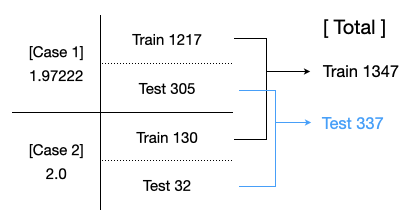

In [ ]:
# X_train['dye_down_rate1'].value_counts()

In [ ]:
# X_test['dye_down_rate1'].value_counts()

### Binary Features

In [12]:
nuniq = df_origin.nunique()
bicols = nuniq[nuniq == 2].index.values
over2 = nuniq[nuniq > 2].index.values
print(f"Number of Binary Features: {len(bicols)}")

Number of Binary Features: 16


# 염색 하강속도 #1

In [13]:
target = bicols[0]
target

'dye_down_rate1'

In [14]:
df_origin[target].value_counts()

1.97222    1522
2.00000     162
Name: dye_down_rate1, dtype: int64

### 케이스 분리 학습

In [15]:
def train_target_value(target, value, X_train_total, X_test_total, y_train_total, y_test_total, model):
    '''
    target : Binary value인 컬럼들(bicols) 중 택1
    value  : binary value 중 하나
    model  : XGBRegressor()
    '''
    print(f"\n===  {target} = {value}  ===")
    
    # Select one target value
    X_train = X_train_total.loc[X_train_total[target] == value, over2[3:]]
    X_test  = X_test_total.loc[X_test_total[target] == value, over2[3:]]
    y_train = y_train_total.loc[X_train.index]
    y_test  = y_test_total.loc[X_test.index]
    print('Train:', X_train.shape, y_train.shape)
    print('Test :', X_test.shape, y_test.shape)

    # Model Training - XGBoost
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    df_train_pred = pd.DataFrame(y_train_pred, columns=['L_train_pred', 'a_train_pred', 'b_train_pred'])

    # Prediction
    y_pred = model.predict(X_test)
    df_pred = pd.DataFrame(y_pred, columns=['L_split', 'a_split', 'b_split'])

    # Performance Evaluation
    print(f'\n[Train] R-squared: {round(model.score(X_train, y_train),5)}')
    print(f'[Test]  R-squared: {round(model.score(X_test, y_test),5)}')
    print(f'[Train] MSE: {round(mean_squared_error(y_train, y_train_pred), 4)}')
    print(f'[Test]  MSE: {round(mean_squared_error(y_test, y_pred),4)}')

    # Train Dataset
    df_train_pred['Delta_E'] = compute_delta_e(y_train, y_train_pred)
    df_train_pred['Below 1'] = (df_train_pred['Delta_E'] < 1)
    print(f"\n[Train] ΔE < 1 : {df_train_pred['Below 1'].sum()} / {len(df_train_pred)} = {df_train_pred['Below 1'].mean():.4f}")
    print(f"[Train] Average of ΔE : {df_train_pred['Delta_E'].mean():.4f}")

    # Test Dataset
    df_pred['Delta_E_split'] = compute_delta_e(y_test, y_pred)
    df_pred['Below 1_split'] = (df_pred['Delta_E_split'] < 1)
    print(f"[Test]  ΔE < 1 : {df_pred['Below 1_split'].sum()} / {len(df_pred)} = {df_pred['Below 1_split'].mean():.4f}")
    print(f"[Test]  Average of ΔE : {df_pred['Delta_E_split'].mean():.4f}")

    return df_train_pred, df_pred

- Model Training & Evaluation

In [16]:
target_values = sorted(df_origin[target].unique()) # 2 elements
df_split, df_train_preds, df_preds = [], [], []

for i, v in enumerate(target_values):
    df_train_pred, df_pred = train_target_value(target, v, X_train, X_test, y_train, y_test, model_xgb)
    df_train_preds.append(df_train_pred)    
    df_preds.append(df_pred)



===  dye_down_rate1 = 1.97222  ===
Train: (1217, 35) (1217, 3)
Test : (305, 35) (305, 3)

[Train] R-squared: 0.99996
[Test]  R-squared: 0.9725
[Train] MSE: 0.0235
[Test]  MSE: 15.9988

[Train] ΔE < 1 : 1214 / 1217 = 0.9975
[Train] Average of ΔE : 0.1019
[Test]  ΔE < 1 : 197 / 305 = 0.6459
[Test]  Average of ΔE : 1.6190

===  dye_down_rate1 = 2.0  ===
Train: (130, 35) (130, 3)
Test : (32, 35) (32, 3)

[Train] R-squared: 1.0
[Test]  R-squared: 0.98875
[Train] MSE: 0.001
[Test]  MSE: 2.9528

[Train] ΔE < 1 : 130 / 130 = 1.0000
[Train] Average of ΔE : 0.0215
[Test]  ΔE < 1 : 25 / 32 = 0.7812
[Test]  Average of ΔE : 1.0230


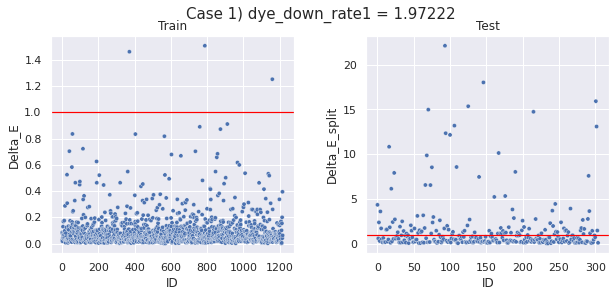

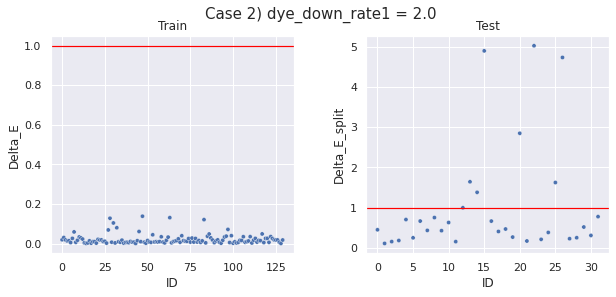

In [18]:
for i in range(2):
    fig, axes = plt.subplots(1,2, figsize=(10,4))
    plt.subplots_adjust(wspace=0.3)
    sns.set_theme(style='darkgrid')
    fig.suptitle(f'Case {i+1}) {target} = {sorted(df_origin[target].unique())[i]}', fontsize=15)

    sns.scatterplot(ax=axes[0], x=df_train_preds[i].index, y=df_train_preds[i]['Delta_E'], size=1, legend=False)
    axes[0].axhline(1.0, 0, 1, color='red', linewidth=1.2)
    axes[0].set_title('Train', fontsize=12)
    axes[0].set_xlabel('ID')

    sns.scatterplot(ax=axes[1], x=df_preds[i].index, y=df_preds[i]['Delta_E_split'], size=1, legend=False)
    axes[1].axhline(1.0, 0, 1, color='red', linewidth=1.2)
    axes[1].set_title('Test', fontsize=12)
    axes[1].set_xlabel('ID')
    plt.show()

### 전체 학습

In [19]:
def train_total(X_train, X_test, y_train, y_test, model):
    print('Train:', X_train.shape, y_train.shape)
    print('Test :', X_test.shape, y_test.shape)

    # Model Training - XGBoost
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    df_train_pred = pd.DataFrame(y_train_pred, columns=['L_train_pred', 'a_train_pred', 'b_train_pred'])

    # Prediction
    y_pred = model.predict(X_test)
    df_pred = pd.DataFrame(y_pred, columns=['L_total', 'a_total', 'b_total'])

    # Performance Evaluation
    print(f'\n[Train] R-squared: {round(model.score(X_train, y_train),5)}')
    print(f'[Test]  R-squared: {round(model.score(X_test, y_test),5)}')
    print(f'[Train] MSE: {round(mean_squared_error(y_train, y_train_pred), 4)}')
    print(f'[Test]  MSE: {round(mean_squared_error(y_test, y_pred),4)}')

    # Train Dataset
    df_train_pred['Delta_E'] = compute_delta_e(y_train, y_train_pred)
    df_train_pred['Below 1'] = (df_train_pred['Delta_E'] < 1)
    print(f"\n[Train] ΔE < 1 : {df_train_pred['Below 1'].sum()} / {len(df_train_pred)} = {df_train_pred['Below 1'].mean():.4f}")
    print(f"[Train] Average of ΔE : {df_train_pred['Delta_E'].mean():.4f}")

    # Test Dataset
    df_pred['Delta_E_total'] = compute_delta_e(y_test, y_pred)
    df_pred['Below 1_total'] = (df_pred['Delta_E_total'] < 1)
    print(f"[Test]  ΔE < 1 : {df_pred['Below 1_total'].sum()} / {len(df_pred)} = {df_pred['Below 1_total'].mean():.4f}")
    print(f"[Test]  Average of ΔE : {df_pred['Delta_E_total'].mean():.4f}")

    return df_train_pred, df_pred

In [20]:
df_train_pred_total, df_pred_total = train_total(X_train, X_test, y_train, y_test, model_xgb)

Train: (1347, 51) (1347, 3)
Test : (337, 51) (337, 3)

[Train] R-squared: 0.99997
[Test]  R-squared: 0.97536
[Train] MSE: 0.0165
[Test]  MSE: 14.0384

[Train] ΔE < 1 : 1346 / 1347 = 0.9993
[Train] Average of ΔE : 0.0940
[Test]  ΔE < 1 : 217 / 337 = 0.6439
[Test]  Average of ΔE : 1.5440


### 전체 vs 분리 학습 결과 비교

In [21]:
df_pred_split = pd.concat([df_preds[0], df_preds[1]])  # Case 1: 1.9722 (305), Case 2: 2.0 (32)
df_pred_split.index = y_test.index
df_pred_total.index = y_test.index
results = pd.concat([y_test, df_pred_split, df_pred_total], axis=1)
results.head()

,L*,a*,b*,L_split,a_split,b_split,Delta_E_split,Below 1_split,L_total,a_total,b_total,Delta_E_total,Below 1_total
568,32.045,-1.775,-2.125,39.296848,-1.705132,-1.880675,4.334960,False,36.692562,-1.760125,-2.563962,2.825683,False
785,54.385,-17.210,13.315,55.670631,-17.036119,13.346696,0.578356,True,56.494446,-17.661177,13.658286,0.984556,True
260,71.120,-11.960,-5.250,67.320381,-11.106228,-3.284471,2.372141,False,67.850296,-10.835315,-3.492105,2.144214,False
1539,34.610,22.230,-15.385,34.473179,21.883984,-15.579975,0.293674,True,34.475040,21.865505,-15.591627,0.308630,True
308,50.190,6.850,-20.250,48.740875,6.691017,-14.795526,3.595891,False,47.497429,6.679363,-14.512350,3.921180,False


In [22]:
results['is_same'] = results['Below 1_split'] == results['Below 1_total']
len(results) - results['is_same'].sum()  # 전체 데이터와 케이스 분리 학습시켰을 떄 결과가 달라지는 경우 147개 / 337개

147

In [23]:
results['Case'] = 0
results.loc[X_test.loc[X_test[target]==target_values[0], :].index, 'Case'] = 1
results.loc[X_test.loc[X_test[target]==target_values[1], :].index, 'Case'] = 2

In [ ]:
# ids_changed = results.loc[results['is_same'] == False, :].index
# ids_same = results.loc[results['is_same'] == True, :].index

# print(X_test.loc[ids_changed, target].value_counts())
# print(X_test.loc[ids_same, target].value_counts())

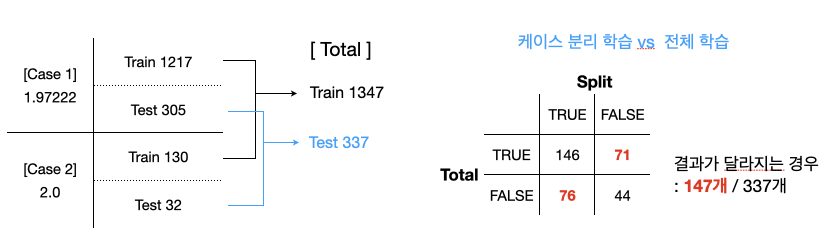

In [30]:
# print('Split = T, Total = T : ', len(results[results['Below 1_split'] & results['Below 1_total']]))
# print('Split = F, Total = F : ', len(results[~results['Below 1_split'] & ~results['Below 1_total']]))

print('\nSplit = F, Total = T : ', len(results[~results['Below 1_split'] & results['Below 1_total']]))
print(results.loc[~results['Below 1_split'] & results['Below 1_total'], 'Case'].value_counts())

print('\nSplit = T, Total = F : ', len(results[results['Below 1_split'] & ~results['Below 1_total']]))
print(results.loc[results['Below 1_split'] & ~results['Below 1_total'], 'Case'].value_counts())


Split = F, Total = T :  71
1    61
2    10
Name: Case, dtype: int64

Split = T, Total = F :  76
1    71
2     5
Name: Case, dtype: int64


Case 1,2 사이에 Trade-off 가 발생하는 것 같다.

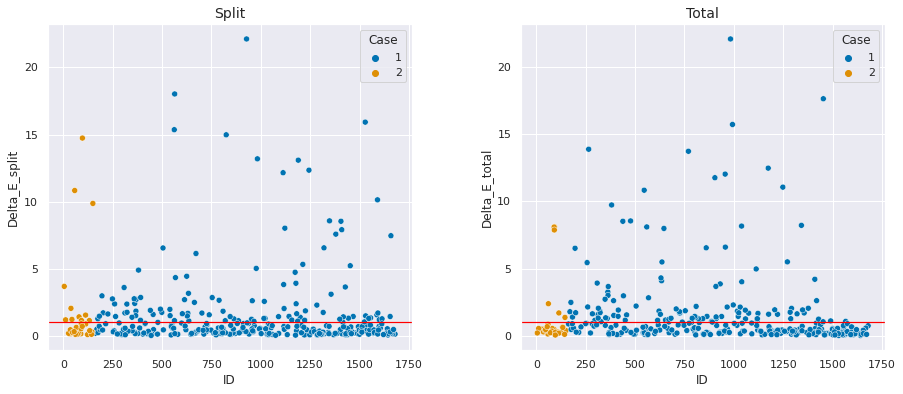

In [31]:
# gap = results['Delta_E_split'] - results['Delta_E_total']

fig, axes = plt.subplots(1,2, figsize=(15,6))
plt.subplots_adjust(wspace=0.3)
sns.set_theme(style='darkgrid')

sns.scatterplot(ax=axes[0], x=results.index, y=results['Delta_E_split'], legend=True,
                hue=results['Case'], palette='colorblind')
axes[0].axhline(1.0, 0, 1, color='red', linewidth=1.2)
axes[0].set_title('Split', fontsize=14)
axes[0].set_xlabel('ID')

sns.scatterplot(ax=axes[1], x=results.index, y=results['Delta_E_total'], legend=True,
                hue=results['Case'], palette='colorblind')
axes[1].axhline(1.0, 0, 1, color='red', linewidth=1.2)
axes[1].set_title('Total', fontsize=14)
axes[1].set_xlabel('ID')

# sns.scatterplot(ax=axes[2], x=results.index, y=gap, legend=True,
#                 hue=results['Case'], palette='colorblind')
# axes[2].axhline(0.0, 0, 1, color='red', linewidth=1.2)
# axes[2].set_title('Gap (Split - Total)', fontsize=14)
# axes[2].set_xlabel('ID')

# sns.scatterplot(ax=axes[1], x=ids_same, y=gap[ids_same], legend=True,
#                 hue=results.loc[ids_same, 'Case'], palette='colorblind')
# axes[1].axhline(0.0, 0, 1, color='red', linewidth=1.2)
# axes[1].set_title('Same', fontsize=14)
# axes[1].set_xlabel('ID')

plt.show()

In [45]:
print(y_train.mean())
print(y_train.std())

L*    51.137418
a*    12.039380
b*    11.202034
dtype: float64
L*    21.546080
a*    21.454884
b*    28.239400
dtype: float64


# 염색 상승온도 #3 유지시간

In [32]:
target = 'dye_up_temp3_hold'
df_origin[target].value_counts()

60.0    1285
10.0      57
20.0      57
30.0      57
40.0      57
50.0      57
70.0      57
80.0      57
Name: dye_up_temp3_hold, dtype: int64

### 케이스 분리 학습

In [81]:
def train_predict(df_origin, target, model):
    '''
    target = Binary value인 컬럼들(bicols) 중 택1
    model = XGBRegressor()
    '''
    target_values = sorted(df_origin[target].unique()) # 2 elements
    df_split, df_train_preds, df_preds = [], [], []
    train_sets, test_sets = [], []

    for i, v in enumerate(target_values):
        df = df_origin.loc[df_origin[target] == v, over2]
        X, y = df.iloc[:,3:], df.iloc[:,:3]
        print(f"\n=== Case {i+1}) {target} = {v} ===")
        print('Total:', X.shape, y.shape)

        # Train, Test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
        print('Train:', X_train.shape, y_train.shape)
        print('Test :', X_test.shape, y_test.shape)

        # Model Training - XGBoost
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        df_train_pred = pd.DataFrame(y_train_pred, columns=['L_train_pred', 'a_train_pred', 'b_train_pred'])

        # Prediction
        y_pred = model.predict(X_test)
        df_pred = pd.DataFrame(y_pred, columns=['L_pred', 'a_pred', 'b_pred'])

        # Performance Evaluation
        print(f'\n[Train] R-squared: {round(model.score(X_train, y_train),5)}')
        print(f'[Test]  R-squared: {round(model.score(X_test, y_test),5)}')
        print(f'[Train] MSE: {round(mean_squared_error(y_train, y_train_pred), 4)}')
        print(f'[Test]  MSE: {round(mean_squared_error(y_test, y_pred),4)}')

        # Train Dataset
        df_train_pred['Delta_E'] = compute_delta_e(y_train, y_train_pred)
        df_train_pred['Below 1'] = (df_train_pred['Delta_E'] < 1)
        print(f"\n[Train] ΔE < 1 : {df_train_pred['Below 1'].sum()} / {len(df_train_pred)} = {df_train_pred['Below 1'].mean():.4f}")
        print(f"[Train] Average of ΔE : {df_train_pred['Delta_E'].mean():.4f}")

        # Test Dataset
        df_pred['Delta_E'] = compute_delta_e(y_test, y_pred)
        df_pred['Below 1'] = (df_pred['Delta_E'] < 1)
        print(f"[Test]  ΔE < 1 : {df_pred['Below 1'].sum()} / {len(df_pred)} = {df_pred['Below 1'].mean():.4f}")
        print(f"[Test]  Average of ΔE : {df_pred['Delta_E'].mean():.4f}")

        df_split.append(df)
        df_train_preds.append(df_train_pred)
        df_preds.append(df_pred)
        train_sets.append((X_train, y_train))
        test_sets.append((X_test, y_test))

    return df_split, df_train_preds, df_preds, train_sets, test_sets

In [86]:
#=====  XGBoost  =====
BOOSTER = 'gbtree' # default. Gradient Boosting tree
LR = 0.05
MAX_DEPTH = 10
N_ESTIMATORS = 50
OBJECTIVE = 'reg:squarederror'
SILENT = False
SUBSAMPLE = 1.0  # Subsample ratio from the training set

colsample_bylevel = 1.0
colsample_bytree = 1.0
EARLY_STOPPING_ROUNDS = 5  # 에러가 n번 증가하면 학습 중단, default 10
GAMMA = 0.0
MAX_DELTA_STEP = 0.0
min_child_weights = 1.0 # Minimum sum of weights needed in each child node for a split.
num_parallel_tree = 1

In [87]:
model_xgb = MultiOutputRegressor(xgb.XGBRegressor(
    booster=BOOSTER, # 'dart': Adds dropout to the standard gradient boosting algorithm
    learning_rate=LR,
    max_depth=MAX_DEPTH,
    n_estimators=N_ESTIMATORS,
    objective=OBJECTIVE,
    silent=SILENT,
    subsample=SUBSAMPLE,
))

In [88]:
df_split, df_train_preds, df_preds, _, _ = train_predict(df_origin, target, model_xgb)


=== Case 1) dye_up_temp3_hold = 10.0 ===
Total: (57, 35) (57, 3)
Train: (45, 35) (45, 3)
Test : (12, 35) (12, 3)

[Train] R-squared: 0.94361
[Test]  R-squared: 0.26566
[Train] MSE: 32.0908
[Test]  MSE: 339.3212

[Train] ΔE < 1 : 0 / 45 = 0.0000
[Train] Average of ΔE : 3.5907
[Test]  ΔE < 1 : 0 / 12 = 0.0000
[Test]  Average of ΔE : 16.3271

=== Case 2) dye_up_temp3_hold = 20.0 ===
Total: (57, 35) (57, 3)
Train: (45, 35) (45, 3)
Test : (12, 35) (12, 3)

[Train] R-squared: 0.94267
[Test]  R-squared: 0.25627
[Train] MSE: 33.1323
[Test]  MSE: 344.5764

[Train] ΔE < 1 : 0 / 45 = 0.0000
[Train] Average of ΔE : 3.6050
[Test]  ΔE < 1 : 0 / 12 = 0.0000
[Test]  Average of ΔE : 16.8228

=== Case 3) dye_up_temp3_hold = 30.0 ===
Total: (57, 35) (57, 3)
Train: (45, 35) (45, 3)
Test : (12, 35) (12, 3)

[Train] R-squared: 0.94235
[Test]  R-squared: 0.24899
[Train] MSE: 33.6565
[Test]  MSE: 346.74

[Train] ΔE < 1 : 0 / 45 = 0.0000
[Train] Average of ΔE : 3.6459
[Test]  ΔE < 1 : 0 / 12 = 0.0000
[Test]  

8가지 값으로 케이스를 나누면 학습이 하나도 안 된다....

### 57개의 의미??

In [36]:
df_origin[target].value_counts()

60.0    1285
10.0      57
20.0      57
30.0      57
40.0      57
50.0      57
70.0      57
80.0      57
Name: dye_up_temp3_hold, dtype: int64

In [74]:
df_10 = df_origin.loc[df_origin[target]==10.0, df_origin.columns[3:]]
df_20 = df_origin.loc[df_origin[target]==20.0, df_origin.columns[3:]]
(df_10.values == df_20.values).sum(axis=1)

array([50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50])

In [72]:
(df_10.values == df_origin.loc[df_origin[target]==80.0, df_origin.columns[3:]].values).sum(axis=1)

array([50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50])

염색 상승온도 #3 유지시간 = 60분 을 제외하고, \
나머지 10, 20, 30, 40, 50, 70, 80분인 경우에
염료 배합 비율을 57가지 조합으로 동일하게 실험한 데이터임.

In [78]:
for col in df_10.columns:
    if df_10[col].nunique() == 1 and df_20[col].nunique() == 1: continue
    print()
    print('='*10, col, '='*10)
    print(df_10[col].value_counts())
    print(df_20[col].value_counts())


========== Dianix Yellow AM-2R ==========
0.00    54
0.05     1
2.00     1
6.00     1
Name: Dianix Yellow AM-2R, dtype: int64
0.00    54
0.05     1
2.00     1
6.00     1
Name: Dianix Yellow AM-2R, dtype: int64

========== Dianix Red AM-SLR ==========
0.00    54
0.05     1
2.00     1
6.00     1
Name: Dianix Red AM-SLR, dtype: int64
0.00    54
0.05     1
2.00     1
6.00     1
Name: Dianix Red AM-SLR, dtype: int64

========== Dianix Blue AM-2G ==========
0.00    54
0.05     1
2.00     1
6.00     1
Name: Dianix Blue AM-2G, dtype: int64
0.00    54
0.05     1
2.00     1
6.00     1
Name: Dianix Blue AM-2G, dtype: int64

========== Dorosperse Yellow KKL ==========
0.000    39
2.000     4
0.017     3
0.667     3
0.033     2
1.333     2
4.000     2
0.050     1
6.000     1
Name: Dorosperse Yellow KKL, dtype: int64
0.000    39
2.000     4
0.017     3
0.667     3
0.033     2
1.333     2
4.000     2
0.050     1
6.000     1
Name: Dorosperse Yellow KKL, dtype: int64

========== Dorosperse Red KKL ===

# Lab 평균 및 표준편차

In [45]:
print("===  Total Data Distribution  ===")
print(f"L* : mean = {df_origin['L*'].mean():.4f}, std = {df_origin['L*'].std():.4f}")
print(f"a* : mean = {df_origin['a*'].mean():.4f}, std = {df_origin['a*'].std():.4f}")
print(f"b* : mean = {df_origin['b*'].mean():.4f}, std = {df_origin['b*'].std():.4f}")

for i in range(2):
    v = sorted(df_origin[target].unique())[i]
    print(f"\n=== Case {i+1}) {target} = {v} ===")
    print(f"L* : mean = {df_split[i]['L*'].mean():.4f}, std = {df_split[i]['L*'].std():.4f}")
    print(f"a* : mean = {df_split[i]['a*'].mean():.4f}, std = {df_split[i]['a*'].std():.4f}")
    print(f"b* : mean = {df_split[i]['b*'].mean():.4f}, std = {df_split[i]['b*'].std():.4f}")

===  Total Data Distribution  ===
L* : mean = 51.1327, std = 21.4002
a* : mean = 12.4984, std = 21.8250
b* : mean = 11.2001, std = 28.0358

=== Case 1) dye_down_rate1 = 1.97222 ===
L* : mean = 52.8434, std = 21.2576
a* : mean = 13.2437, std = 22.5964
b* : mean = 11.6233, std = 28.9184

=== Case 2) dye_down_rate1 = 2.0 ===
L* : mean = 35.0606, std = 15.1888
a* : mean = 5.4962, std = 10.0487
b* : mean = 7.2240, std = 17.2739


# 함수 수정 전

In [ ]:
# def train_target_value(target, value, df, model):
#     '''
#     target : Binary value인 컬럼들(bicols) 중 택1
#     value  : binary value 중 하나
#     model  : XGBRegressor()
#     '''
#     print(f"\n===  {target} = {value}  ===")
    
#     # Train, Test split
#     X, y = df.iloc[:,3:], df.iloc[:,:3]
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
#     print('Total:', X.shape, y.shape)
#     print('Train:', X_train.shape, y_train.shape)
#     print('Test :', X_test.shape, y_test.shape)

#     # Model Training - XGBoost
#     model.fit(X_train, y_train)
#     y_train_pred = model.predict(X_train)
#     df_train_pred = pd.DataFrame(y_train_pred, columns=['L_train_pred', 'a_train_pred', 'b_train_pred'])

#     # Prediction
#     y_pred = model.predict(X_test)
#     df_pred = pd.DataFrame(y_pred, columns=['L_pred', 'a_pred', 'b_pred'])

#     # Performance Evaluation
#     print(f'\n[Train] R-squared: {round(model.score(X_train, y_train),5)}')
#     print(f'[Test]  R-squared: {round(model.score(X_test, y_test),5)}')
#     print(f'[Train] MSE: {round(mean_squared_error(y_train, y_train_pred), 4)}')
#     print(f'[Test]  MSE: {round(mean_squared_error(y_test, y_pred),4)}')

#     # Train Dataset
#     df_train_pred['Delta_E'] = compute_delta_e(y_train, y_train_pred)
#     df_train_pred['Below 1'] = (df_train_pred['Delta_E'] < 1)
#     print(f"\n[Train] ΔE < 1 : {df_train_pred['Below 1'].sum()} / {len(df_train_pred)} = {df_train_pred['Below 1'].mean():.4f}")
#     print(f"[Train] Average of ΔE : {df_train_pred['Delta_E'].mean():.4f}")

#     # Test Dataset
#     df_pred['Delta_E'] = compute_delta_e(y_test, y_pred)
#     df_pred['Below 1'] = (df_pred['Delta_E'] < 1)
#     print(f"[Test]  ΔE < 1 : {df_pred['Below 1'].sum()} / {len(df_pred)} = {df_pred['Below 1'].mean():.4f}")
#     print(f"[Test]  Average of ΔE : {df_pred['Delta_E'].mean():.4f}")

#     return df_train_pred, df_pred, (X_train, X_test, y_train, y_test)